In [ ]:
#import all libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split as tts
from bs4 import BeautifulSoup
from attention import AttentionLayer
import matplotlib.pyplot as plt
import pickle

In [ ]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
#load the data
df = pd.read_csv("/content/Reviews.csv", nrows=250000)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
#Drop Duplicates and NAs
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15638 entries, 0 to 16241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      15638 non-null  int64  
 1   ProductId               15638 non-null  object 
 2   UserId                  15638 non-null  object 
 3   ProfileName             15638 non-null  object 
 4   HelpfulnessNumerator    15638 non-null  float64
 5   HelpfulnessDenominator  15638 non-null  float64
 6   Score                   15638 non-null  float64
 7   Time                    15638 non-null  float64
 8   Summary                 15638 non-null  object 
 9   Text                    15638 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.3+ MB


In [ ]:
#Preprocessing
#Text Cleaning
#define a dictionary for contracition mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def text_cleaner(text, num):
    """
    This function cleans a text by removing everything :)
    """
    #define new string
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)

    #Clean texts with number 0
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]

    #Clean Summaries with number 1
    else:
        tokens=newString.split()

    long_words = []
    for i in tokens:
        if len(i) > 1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
#clean the text
cleaned_texts = []

for t in df["Text"]:
    cleaned_texts.append(text_cleaner(t, 0))

In [ ]:
#clean summaries
cleaned_summaries = []

for s in df["Summary"]:
    cleaned_summaries.append(text_cleaner(s, 1))

In [ ]:
#create new dataframe for the cleaned texts and summaries
dataframe = pd.DataFrame(columns=["text", "summary"])
#put cleaned version of texts and summaries into the dataframe
dataframe["text"] = cleaned_texts
dataframe["summary"] = cleaned_summaries

In [ ]:
dataframe

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...
15633,must say great offer use keurig brewer everyday favorite coffee shop everyday amazon good deals important trust amazon selling described bought coffee many places best price keep good work amazon ...,great offer
15634,product original packages individual kcups loose box also shown ship prime took week,diappointed
15635,least strong bitter coffee find cups like strong coffee one enjoy came variety pack came coffee maker,little bitter but ok
15636,love green mountain coffee tastes great keurig best price yet would definitely continue buy usually go box per month found economical purchase,price is right


In [ ]:
dataframe.replace('', np.nan, inplace=True)
dataframe.dropna(axis=0,inplace=True)

In [ ]:
#define text and summary max lengths
MAX_TEXT_LEN = 50
MAX_SUMMARY_LEN = 10

In [ ]:
#Just keep summaries and text within limits
#make the texts and summaries some arrays
cleaned_text = np.array(dataframe["text"])
cleaned_summary = np.array(dataframe["summary"])

#define lists for short text and short summaries
short_text = []
short_summary = []

#clean outliers
for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

#change the dataframe
final_dataframe = pd.DataFrame({"text":short_text, "summary":short_summary})

In [ ]:
#Adding Tokens
final_dataframe["summary"] = final_dataframe["summary"].apply(lambda x: "soseq " + x + " eoseq")

In [ ]:
#print wome sample of the dataframe
for i in range(3):
  print("\033[1m" + "Text: " + "\033[0m" + final_dataframe["text"][i])
  print("\033[1m" + "Summary: " + "\033[0m" + final_dataframe["summary"][i])
  print("\n")

Text: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: soseq good quality dog food eoseq


Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: soseq not as advertised eoseq


Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: soseq delight says it all eoseq




In [ ]:
#Split data into train, test and validation
#define arrays for datas
texts = np.array(final_dataframe["text"])
summaries = np.array(final_dataframe["summary"])

In [ ]:
#divide train and validation
x_train, x_val, y_train, y_val = tts(texts, summaries, test_size=0.15, random_state=0, shuffle=True)

In [ ]:
#divide test data from the validation data
x_val, x_test, y_val, y_test = tts(x_val, y_val, test_size=0.05, random_state=0, shuffle=True)

In [ ]:
#Tokenization
#Input data tokenization
#define the x tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
#define the threshold
threshold = 4

#define variables for total count, count, frequency and total frequency
count = 0 # Number of rare words
total_count = 0 # count of every unique word in texts
freq = 0
total_freq = 0

for key, value in x_tokenizer.word_counts.items():
  #update counts and frequencies
  total_count += 1
  #if the value of word was lower than our threshold, count!
  if value < threshold:
    count += 1

In [ ]:
#get the top most common words number
common_words = total_count - count

#fit the tokenizer
x_tokenizer = Tokenizer(num_words=common_words)
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequence to int
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

#Zero padding
x_train = pad_sequences(x_train_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_test = pad_sequences(x_test_seq, maxlen=MAX_TEXT_LEN, padding="post")

#get the size of input vocabulary
x_vocab = x_tokenizer.num_words + 1

In [ ]:
print(f"size of input (X) vocabulary: {x_vocab}")

size of input (X) vocabulary: 4964


In [ ]:
#Output data tokenization
#define the tokenizer
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
#define the threshold
threshold = 6

#define variables for total count, count, frequency and total frequency
count = 0 # Number of rare words
total_count = 0 # count of every unique word in texts
freq = 0
total_freq = 0

for key, value in y_tokenizer.word_counts.items():
  #update counts and frequencies
  total_count += 1
  #if the value of word was lower than our threshold, count!
  if value < threshold:
    count += 1

In [ ]:
#get the count of common words
common_words = total_count - count

#fit tokenizer on common words
y_tokenizer = Tokenizer(num_words=common_words)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequence to int
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

#Zero padding
y_train = pad_sequences(y_train_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_val = pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_test = pad_sequences(y_test_seq, maxlen=MAX_SUMMARY_LEN, padding="post")

#get the size of output vocabulary
y_vocab = y_tokenizer.num_words + 1

In [ ]:
print(f"size of output (Y) vocabulary: {y_vocab}")

size of output (Y) vocabulary: 802


In [ ]:
#Remove rows with only start and end tokens
#Train data
#define a list for index
index = []

#loop over train data
for i in range(len(y_train)):
    count = 0
    for j in y_train[i]:
        if j != 0:
            count += 1
        #if count of words were 2, remove the data
    if count == 2:
        index.append(i)

#remove rows
y_train = np.delete(y_train, index, axis=0)
x_train = np.delete(x_train, index, axis=0)

In [ ]:
#Validation data
#define a list for index
index = []

#loop over train data
for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count += 1
        #if count of words were 2, remove the data
    if count == 2:
        index.append(i)

#remove rows
y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

In [ ]:
#Test data
#define a list for index
index = []

#loop over train data
for i in range(len(y_test)):
    count = 0
    for j in y_test[i]:
        if j != 0:
            count += 1
        #if count of words were 2, remove the data
    if count == 2:
        index.append(i)

#remove rows
y_test = np.delete(y_test, index, axis=0)
x_test = np.delete(x_test, index, axis=0)

In [ ]:
x_train[0]

array([   7,  161,   65,   93,  195,  282,   79,   73,  225,  161,    2,
       2328,   56,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
#setup the datas for training
x_train_m = [x_train, y_train[:,:-1]]
y_train_m = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
x_val_m = [x_val, y_val[:,:-1]]
y_val_m = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [ ]:
#define hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
LATENT_DIM = 250
EMBED_DIM = 90

In [ ]:
#Model Building
#-------------------------------------------------------------------- < Encoder > --------------------------------------------------------------------
#define the input
encoder_input = Input(shape=(MAX_TEXT_LEN, ), name="encoder_input")

#Embedding
encoder_embed = Embedding(x_vocab, EMBED_DIM, trainable=True, name="encoder_embeding")(encoder_input)

#Encoder LSTM Block 1
encoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_1")
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)

#Encoder LSTM Block 2
encoder_lstm2 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_2")
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#Encoder LSTM Block 3
encoder_lstm3 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_3")
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

#-------------------------------------------------------------------- < Decoder > --------------------------------------------------------------------
#define the input
decoder_input = Input(shape=(None, ), name="decoder_input")

#Embedding for Decoder
decoder_embed_layer = Embedding(y_vocab, EMBED_DIM, trainable=True)
decoder_embed = decoder_embed_layer(decoder_input)

#Decoder LSTM
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="decoder_lstm")
decoder_lstm_output, decoder_h1, decoder_c1 = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

#Attention Layer
attention_layer = AttentionLayer(name="attention_layer")
attention_output, attention_state = attention_layer([encoder_output3, decoder_lstm_output])

#concatinate decoder and attention otuputs
decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output, attention_output])

#Time Distributed Dense
decoder_dense = TimeDistributed(Dense(y_vocab, activation="softmax"))
decoder_output = decoder_dense(decoder_concat)

#define the final model
model = Model([encoder_input, decoder_input], decoder_output)

In [ ]:
#see the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 50)]                 0         []                            
                                                                                                  
 encoder_embeding (Embeddin  (None, 50, 90)               446760    ['encoder_input[0][0]']       
 g)                                                                                               
                                                                                                  
 enc_lstm_1 (LSTM)           [(None, 50, 250),            341000    ['encoder_embeding[0][0]']    
                              (None, 250),                                                        
                              (None, 250)]                                                    

In [ ]:
#compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=0.0001)

In [ ]:
#Model Training
history = model.fit(x_train_m, y_train_m, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_m, y_val_m), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
39/39 [==============================] - 219s 6s/step - loss: 2.4703 - accuracy: 0.5802 - val_loss: 2.3906 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 215s 6s/step - loss: 2.3670 - accuracy: 0.6053 - val_loss: 2.2155 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - 213s 5s/step - loss: 2.1822 - accuracy: 0.6557 - val_loss: 2.0821 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 4/50
39/39 [==============================] - 218s 6s/step - loss: 2.1035 - accuracy: 0.6719 - val_loss: 2.0500 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 5/50
39/39 [==============================] - 220s 6s/step - loss: 2.0806 - accuracy: 0.6719 - val_loss: 2.0470 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 6/50
39/39 [==============================] - 220s 6s/step - loss: 2.0702 - accuracy: 0.6719 - val_loss: 2.0311 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 7/50
39/39 [==============================] - 219s 6s/step - loss: 2.0

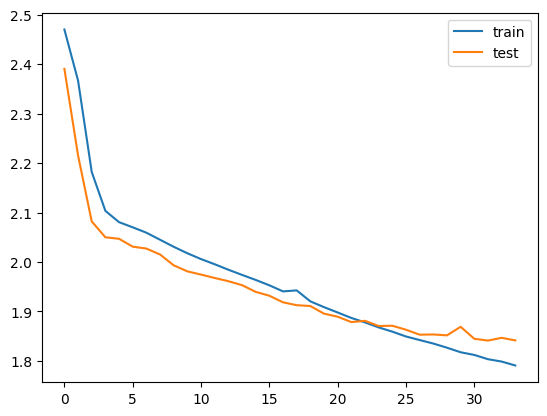

In [ ]:
#fraw plots
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

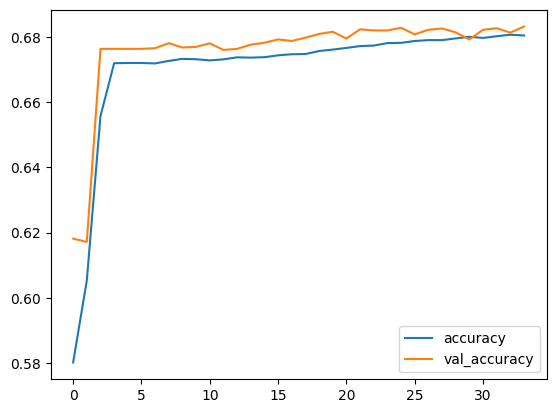

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

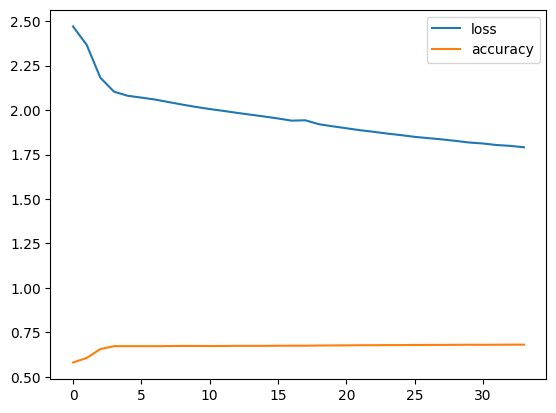

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

In [ ]:
#Model Testing and Evaluation
#save the tokenizer
with open('xtokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Ready layers for prediction
#set tokenizerz for predictions
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
#define s single model for encoder
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

#---------- < DECODER > ----------
#define inputs
decoder_input_state_h = Input(shape=(LATENT_DIM, ))
decoder_input_state_c = Input(shape=(LATENT_DIM, ))
decoder_input_state_hidden = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))

#Embedding of the decoder
decoder_embedding_pred = decoder_embed_layer(decoder_input)
#Decoder LSTM (For making prediction, the state of the decoder should be set to the state of its previos time step)
decoder_output_p, state_h_p, state_c_p = decoder_lstm(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])

#Attention
attention_out_inference, attention_state_inference = attention_layer([decoder_input_state_hidden, decoder_output_p])
decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p, attention_out_inference])

#Final prediction
decoder_final_output = decoder_dense(decoder_concat)

#make the final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c],
    [decoder_final_output] + [state_h_p, state_c_p])

In [ ]:
#Sequence decoding
def sequence_decoder(input_sequence):
    """
    This function decods the sequence predicted
    """
    #encode the input
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)
    #Define an embpy target with it's first woed set to input sequence
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_word_index["soseq"]

    #define variables for when to stop and the decoded sentence
    decoded_sentence = ""
    stop = False

    while not stop:
        #when we did not reach the place to stop (eoseq), decode
        output_token, h, c = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c], verbose=None)

        #predict token
        predicted_token_index = np.argmax(output_token[0, -1, :])
        predicted_token = reverse_target_word_index[predicted_token_index]

        #if the token was not end of sequence, continue and add the predicted token to the dcecoded sentence variable
        if  predicted_token != "eoseq":
            decoded_sentence += " " + predicted_token

        #if we've reached eoseq token or reached the summary length limit, make the stop state true
        if predicted_token == "eoseq" or len(decoded_sentence.split()) >= MAX_SUMMARY_LEN - 1:
            stop = True

        #update the target sequence
        target_sequence = np.zeros((1,1))
        target_sequence[0, 0] = predicted_token_index

        #Update internal states
        encoder_h, encoder_c = h, c

    return decoded_sentence


In [ ]:
def sequence_to_summary(input_seuqnece):
    """
    This function converts sequence into text (in this case summary)
    """
    sentence = ""
    #loop over the input sequence
    for i in input_seuqnece:
        if i != 0 and i != target_word_index["soseq"] and i != target_word_index["eoseq"]:
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [ ]:
def sequence_to_text(input_seuqnece):
    """
    This function converts sequence into text (in this case text)
    This function is going to be used only for testing the model on test data
    """
    sentence = ""
    #loop over the input sequence
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [ ]:
for i in range(5, 34):
    print("Review:", sequence_to_text(x_test[i]))
    print("Original summary:", sequence_to_summary(y_test[i]))
    print("Predicted summary:", sequence_decoder(x_test[i].reshape(1,MAX_TEXT_LEN)))
    print("\n")

Review: fabulous use put cheese olives martinis works really well easy clean 
Original summary: anywhere 
Predicted summary:  great product


Review: buy crackers need something gluten free snack gluten free salty wipe salt able eat wish manufacturers would learn free mean eat salt less salt please 
Original summary: bought way amazon chips full 
Predicted summary:  great product


Review: good storage cups well enough storage support keurig coffee maker easily solved problem store cups much better 
Original summary: great bisquick 
Predicted summary:  great coffee


Review: excellent hot chocolate love love hot chocolate go love would purchase 
Original summary: bags 
Predicted summary:  great coffee


Review: found yogi tea local grocery store began amazing love love teas stomach ease one perfect times feeling hot south belly button 
Original summary: recommend food 
Predicted summary:  great coffee


Review: actually bought use safe treat however found using cook anything else taste